In [1]:
import sys
sys.path.append('..')
from src.pomdp import *
from src.mdp import VI_Solver

import numpy as np

# POMDP Toy Problem

Symmetric 2 state, 2 action model

## Model definition

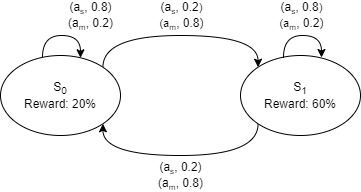

In [2]:
ACTION_COUNT = 2
STATE_COUNT = 2

In [3]:
# 80% chance of success, 10% land in other tile, 10% stay in place
MOVE_RND = 0.9
def transition_function(s, a, s_p):
    s_a = (s + a) % STATE_COUNT
    s_a = s_a if s_a >= 0 else s_a + STATE_COUNT
    
    if s_a == s_p:
        return MOVE_RND
    else:
        return round((1.0 - MOVE_RND) / (STATE_COUNT - 1), 1)

# Setup table to speedup computation
transition_table = np.zeros(shape=(STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            transition_table[s,a,s_p] = transition_function(s,a,s_p)

# Test with action 0, ie: LEFT
transition_table[:,0,:]

array([[0.9, 0.1],
       [0.1, 0.9]])

In [4]:
OBS_RND = 0.7 # 70% of observation success

observation_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s_p in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for o in range(STATE_COUNT):
            observation_table[s_p, a, o] = OBS_RND if s_p == o else (1.0 - OBS_RND) / (STATE_COUNT - 1)
          
observation_table[:,0,:]

array([[0.7, 0.3],
       [0.3, 0.7]])

In [5]:
REWARD_PROBS = [0.2, 0.6]

reward_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            reward_table[s,a,s_p,:] = REWARD_PROBS[s_p]
        
reward_table

array([[[[0.2, 0.2],
         [0.6, 0.6]],

        [[0.2, 0.2],
         [0.6, 0.6]]],


       [[[0.2, 0.2],
         [0.6, 0.6]],

        [[0.2, 0.2],
         [0.6, 0.6]]]])

In [6]:
callable(transition_table)

False

In [7]:
states = ['s0','s1']
actions = ['stay', 'move']
observations = ['s0', 's1']

model = Model(states=states,
              actions=actions,
              observations=observations,
              transitions=transition_table,
              rewards=reward_table,
              observation_table=observation_table,
              rewards_are_probabilistic=True)

[09/25/2023, 01:42:26] Instantiation of MDP Model:
[09/25/2023, 01:42:26] - 2 states
[09/25/2023, 01:42:26] - 2 actions
[09/25/2023, 01:42:26] - Starting generation of transitions table
[09/25/2023, 01:42:26]     > Done in 0.000s
[09/25/2023, 01:42:26] - Generating start probabilities table
[09/25/2023, 01:42:26] - Starting computation of reachable states from transition data
[09/25/2023, 01:42:26]     > Done in 0.001s
[09/25/2023, 01:42:26] - At most 2 reachable states per state-action pair
[09/25/2023, 01:42:26] - Starting computation of reachable state probabilities from transition data
[09/25/2023, 01:42:26]     > Done in 0.000s
[09/25/2023, 01:42:26] POMDP particular parameters:
[09/25/2023, 01:42:26] - 2 observations
[09/25/2023, 01:42:26] - Starting of transitional observations for reachable states table
[09/25/2023, 01:42:26]     > Done in 0.000s
[09/25/2023, 01:42:26] - Starting generation of expected rewards table
[09/25/2023, 01:42:26]     > Done in 0.000s


## Solving

In [8]:
solver = PBVI_Solver(eps=10e-5)

In [9]:
value_function, solve_history = solver.solve(model,9,10)

Expansions:   0%|          | 0/9 [00:00<?, ?it/s]

Backups 0:   0%|          | 0/10 [00:00<?, ?it/s]

Backups 1:   0%|          | 0/10 [00:00<?, ?it/s]

Backups 2:   0%|          | 0/10 [00:00<?, ?it/s]

Backups 3:   0%|          | 0/10 [00:00<?, ?it/s]

Backups 4:   0%|          | 0/10 [00:00<?, ?it/s]

Backups 5:   0%|          | 0/10 [00:00<?, ?it/s]

Backups 6:   0%|          | 0/10 [00:00<?, ?it/s]

Converged early...


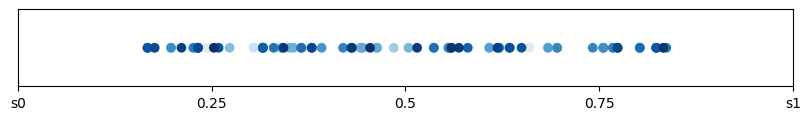

In [10]:
solve_history.plot_belief_set(10)

In [11]:
value_function

<Figure size 600x400 with 0 Axes>

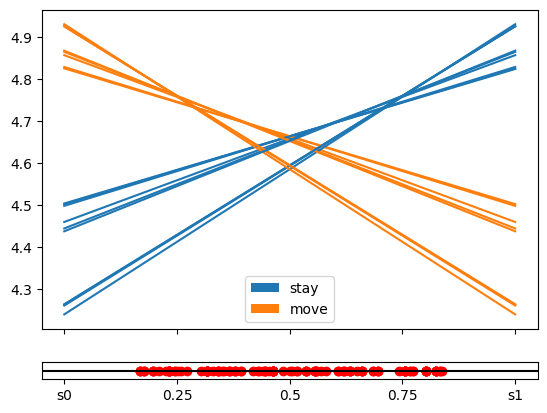

: 

In [12]:
solve_history.plot_solution(4)

In [13]:
# solve_history.save_history_video()

## Simulation

In [13]:
agent = Agent(model)
agent.train(solver, 9, 10)

Expansions:   0%|          | 0/9 [00:00<?, ?it/s]

Backups 0:   0%|          | 0/10 [00:00<?, ?it/s]

Backups 1:   0%|          | 0/10 [00:00<?, ?it/s]

Backups 2:   0%|          | 0/10 [00:00<?, ?it/s]

Backups 3:   0%|          | 0/10 [00:00<?, ?it/s]

Backups 4:   0%|          | 0/10 [00:00<?, ?it/s]

Backups 5:   0%|          | 0/10 [00:00<?, ?it/s]

Backups 6:   0%|          | 0/10 [00:00<?, ?it/s]

Converged early...


In [14]:
sim = Simulation(model)
rewards = agent.simulate(sim, 1000)

AttributeError: 'Model' object has no attribute 'state_grid_points'

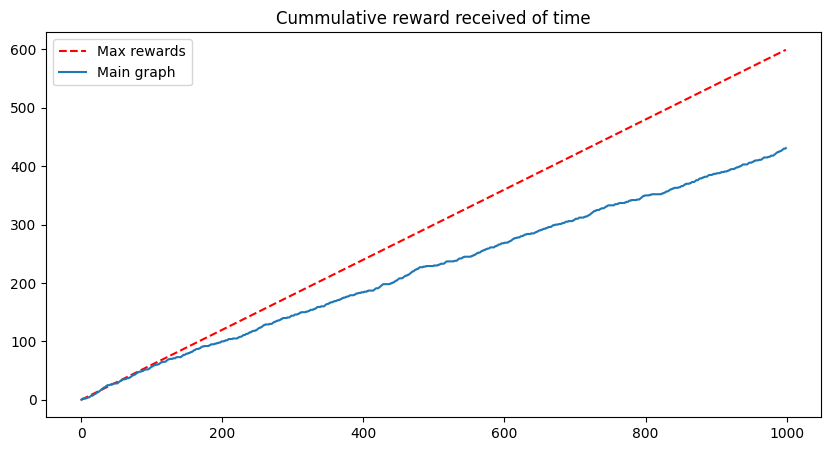

In [ ]:
rewards.plot_rewards(type='total', max_reward=max(REWARD_PROBS))

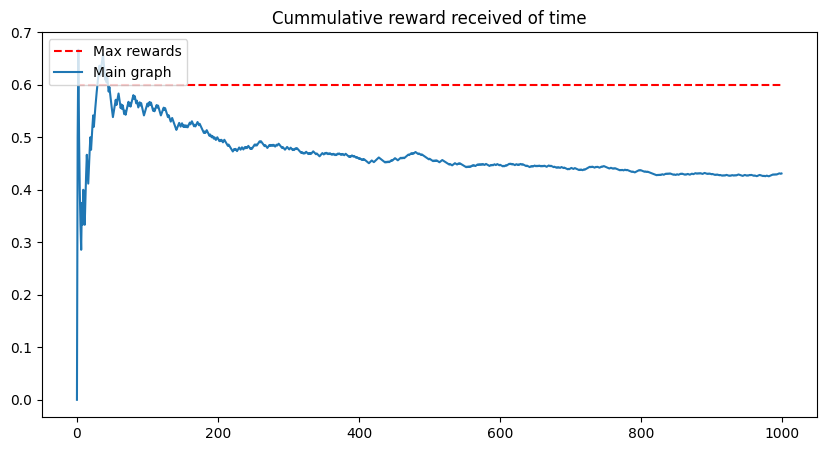

In [ ]:
rewards.plot_rewards(type='moving_average', max_reward=max(REWARD_PROBS))

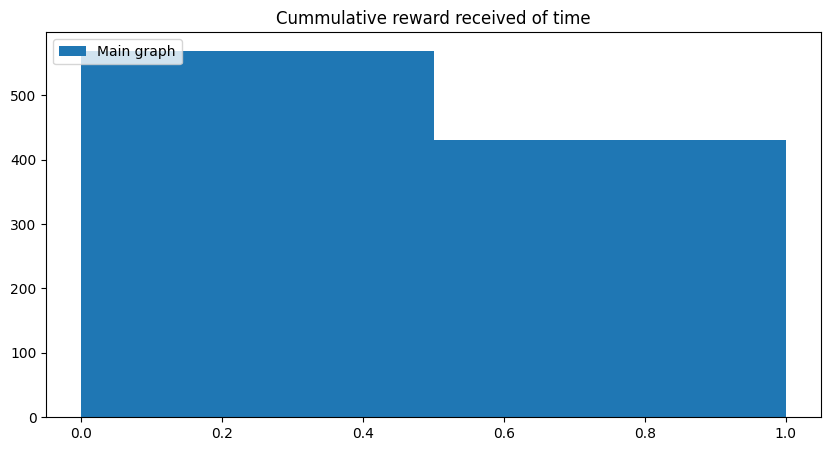

In [ ]:
rewards.plot_rewards(type='histogram', max_reward=max(REWARD_PROBS))

## MDP Version of the probelm

In [ ]:
vi_solver = VI_Solver(gamma=0.9)

In [ ]:
vi_solution, vi_solve_history = vi_solver.solve(model)

  0%|          | 38/10000 [00:00<00:00, 19028.60it/s]


<Figure size 700x500 with 0 Axes>

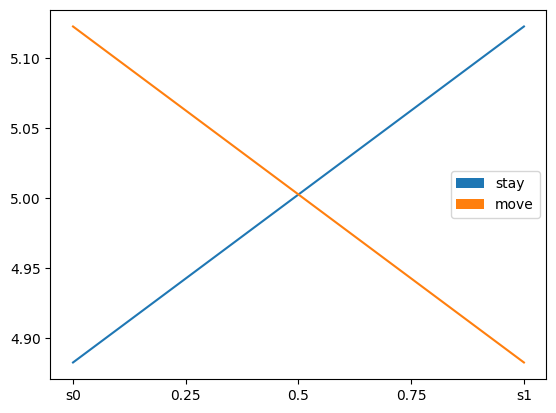

In [ ]:
vi_solution.plot()

In [ ]:
# solve_history.save_history_video(custom_name='comparison', compare_with=vi_solve_history)